<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/07_food_vision_milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone Project 1: Food Vision Big**

What we're going to cover :
* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (making our datasets run fast)
* Creating modelling callbacks
* Setting up mixed precision training
* Building a feature extraction model (see transfer learning part 1: feature extraction)
* Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
* Viewing training results on TensorBoard

## **Check GPU**
We're going to be using mixed precision training.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.


In [8]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dbdf5b38-c197-5a90-e598-820c2f4f1e06)


In [9]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.4.1


## **Get helper functions**

In [13]:
# Get helper functions file
!wget https://raw.githubusercontent.com/prachuryanath/TF-Learning/main/extras/helper_functions.py

--2021-05-19 05:54:48--  https://raw.githubusercontent.com/prachuryanath/TF-Learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2021-05-19 05:54:48 (104 MB/s) - ‘helper_functions.py.1’ saved [10235/10235]



In [14]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## **Use TensorFlow Datasets to Download Data**

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through TensorFlow Datasets (TFDS).

In [15]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [16]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In particular, we'll have to pass it a few parameters to let it know what we're after:

* `name (str)` : the target dataset (e.g. "food101")
* `split (list, optional)` : what splits of the dataset we're after (e.g. ["train", "validation"])
  * the split parameter is quite tricky. See the documentation for more.
* `shuffle_files (bool)` : whether or not to shuffle the files on download, defaults to False
* `as_supervised (bool)` : True to download data samples in tuple format ((data, label)) or False for dictionary format
* `with_info (bool)` : True to download dataset metadata (labels, number of samples, etc)

In [19]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data,test_data), ds_info = tfds.load(name="food101", 
                                            split=["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True, # data gets returned in tuple format(data, label),
                                            with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteZ6RPV9/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteZ6RPV9/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [21]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [22]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets
Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [24]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the as_supervised=True parameter in our tfds.load() method above, data samples come in the tuple format structure (data, label) or in our case (image_tensor, label).

In [25]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [26]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 76
  Class name (str form): pizza
        


Because we set the shuffle_files=True parameter in our tfds.load() method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).



In [27]:
# What does an image tensor from TFS's Food101 look like ?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 74,  76,  75],
        [ 90,  92,  91],
        [ 93,  95,  94],
        ...,
        [ 99, 104, 100],
        [101, 106, 102],
        [103, 108, 104]],

       [[ 83,  85,  84],
        [ 84,  86,  85],
        [ 73,  75,  74],
        ...,
        [ 99, 104, 100],
        [100, 105, 101],
        [102, 107, 103]],

       [[ 81,  83,  82],
        [ 79,  81,  80],
        [ 69,  71,  70],
        ...,
        [ 99, 104, 100],
        [100, 105, 101],
        [101, 106, 102]],

       ...,

       [[ 42,  49,  55],
        [ 44,  51,  57],
        [ 46,  53,  59],
        ...,
        [ 85,  83,  71],
        [ 97,  95,  82],
        [111, 109,  96]],

       [[ 42,  49,  55],
        [ 44,  51,  57],
        [ 46,  53,  59],
        ...,
        [ 98,  96,  84],
        [105, 103,  90],
        [110, 108,  95]],

       [[ 42,  49,  55],
        [ 44,  51,  57],
        [ 46,  53,  59],
        ...,
        [109, 107,  9

In [28]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=13>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

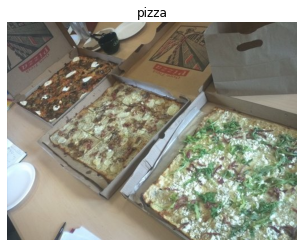

In [29]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## **Create preprocessing functions for our data**
What we know about our data:
* In uint8 datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in float32 dtype (or for mixed precision float16 and float32)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

This means our functions needs to:

* Reshape our images to all the same size
* Convert the dtype of our image tensors from unit8 to float32

In [31]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [33]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 74  76  75]
  [ 90  92  91]
  [ 93  95  94]
  ...
  [ 99 104 100]
  [101 106 102]
  [103 108 104]]

 [[ 83  85  84]
  [ 84  86  85]
  [ 73  75  74]
  ...
  [ 99 104 100]
  [100 105 101]
  [102 107 103]]]..., 
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 84.05612   86.05612   85.05612 ]
  [ 74.11734   76.11734   75.11734 ]
  [ 59.214287  61.214287  60.214287]
  ...
  [ 98.71429  103.71429   99.71429 ]
  [ 98.07144  103.07144   99.07144 ]
  [101.357216 106.357216 102.357216]]

 [[ 80.15306   82.15306   81.15306 ]
  [ 64.30102   66.301025  65.301025]
  [ 75.93367   77.93367   76.93367 ]
  ...
  [ 98.19894  103.19894   99.19894 ]
  [ 98.00512  103.00512   99.00512 ]
  [100.35718  105.35718  101.35718 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## **Batch & prepare datasets**
Before we can model our data, we have to turn it into batches as computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

Specifically, we're going to be using:

* `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
* `shuffle()` - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
* `batch()` - turns elements of a target dataset into batches (size defined by parameter batch_size)
* `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: `cache()` - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)
---
Things to note:
* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
* For methods with the num_parallel_calls parameter available (such as `map()`), setting it to `num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can 
fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset


In [34]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Create modelling callbacks
* `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [36]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

### Setup mixed precision training

When using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.


In [37]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [38]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

## **Build feature extraction model**

To build the feature extraction model (covered in Transfer Learning in TensorFlow Part 1: Feature extraction), we'll:
* Use EfficientNetB0 from tf.keras.applications pre-trained on ImageNet as our base model
* We'll download this without the top layers using include_top=False parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a Functional model
* Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks


In [39]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [40]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


### Checking layer dtype policies (are we using mixed precision ?)

In [41]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the name parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
* `layer.dtype` : the data type a layer stores its variables in
* layer.dtype_policy : the data type a layer computes in

In [42]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

## **Fit the feature extraction model**

In [43]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210519-072955
Epoch 1/3
2368/2368 [==============================] - 220s 77ms/step - loss: 2.3285 - accuracy: 0.4624 - val_loss: 1.2255 - val_accuracy: 0.6764
Epoch 2/3
2368/2368 [==============================] - 157s 66ms/step - loss: 1.3195 - accuracy: 0.6601 - val_loss: 1.1263 - val_accuracy: 0.6997
Epoch 3/3
2368/2368 [==============================] - 154s 64ms/step - loss: 1.1487 - accuracy: 0.7008 - val_loss: 1.0834 - val_accuracy: 0.7060


In [44]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 67ms/step - loss: 1.0912 - accuracy: 0.7065


[1.0912095308303833, 0.7065346240997314]

### Load and evaluate checkpoint weights
We can load in and evaluate our model's checkpoints by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

In [45]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [46]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [47]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [48]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [49]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 47s 56ms/step - loss: 1.0932 - accuracy: 0.7025


In [50]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all() # check if all elements in array are close

In [51]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

## **Save the whole model to file**

In [52]:
## Saving model to Google Drive (optional)

# Create save path to drive 
save_dir = "drive/MyDrive/Colab Networks/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Networks/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Networks/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [53]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir_1 = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir_1)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [54]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

IGNORE ABOVE WARNINGS !!!

In [55]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [56]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 47s 57ms/step - loss: 1.0912 - accuracy: 0.7065


[1.0912089347839355, 0.7065346240997314]